In [223]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

np.set_printoptions(suppress=True, linewidth=300)

Real: 1064, Fake: 4866


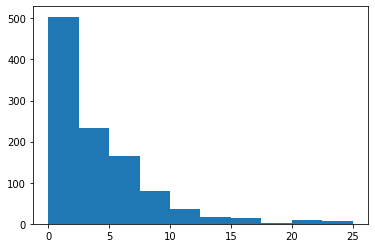

In [129]:
# Open dataframe and set filename as index
df = pd.read_pickle('master_dataframe_updated.pkl')
df.set_index('file', inplace=True)

# Get list of all numpy files with faces detected
npy = list(Path('/media/mc/2TBNVMESSD/train_bboxes/').glob('*.npy'))

# Get list of real and fake numpy files
names = [i.with_suffix('.mp4').name for i in npy]
real = []
fake = []
for name in names:
    label = df.loc[name, 'label']
    if label == 'REAL': real.append(name)
    elif label == 'FAKE': fake.append(name)
    else: print('Unknown label: {}')
print(f'Real: {len(real)}, Fake: {len(fake)}')

# Make dataframe of npy info
npy_df = pd.DataFrame(list(zip(names, npy)), columns=['file', 'npy_file'])
npy_df.set_index('file', inplace=True)
for name in names:
    npy_df.loc[name, 'label'] = df.loc[name, 'label']
    data = np.load(npy_df.loc[name, 'npy_file'], allow_pickle=True)
    npy_df.loc[name, 'num_dets'] = np.array([i.shape[0] for i in data]).mean()

# Make dataframe organizing processed files
proc_df = pd.DataFrame(list(zip(real, [[] for i in real])), columns=['real', 'fakes'])
proc_df.set_index('real', inplace=True)
for name in fake:
    original = df.loc[name, 'original']
    if original in proc_df.index:
        proc_df.loc[original, 'fakes'].append(name)\

# Plot histogram of fakes per real
num = [len(proc_df.iloc[i, 0]) for i in range(len(proc_df))]
plt.hist(num);

### Test saving a video of detected face

In [135]:
# Get real videos with one detection
files = npy_df[(npy_df['num_dets'] == 1.0) & (npy_df['label'] == 'REAL')].index

In [286]:
file = files[1]
out_path = '/home/mc/Desktop/test.mp4'

video = df.loc[file, 'filepath']
boxes = np.load(npy_df.loc[file, 'npy_file'], allow_pickle=True)
boxes = convert_xywh2xyxy(standardize_wh(convert_xyxy2xywh(boxes.squeeze().astype(int)).astype(int)).astype(int)).astype(int)
frames = get_det_from_video(video, boxes)
save_frames(frames, out_path)
#boxes = standardize_boxes(boxes.squeeze(), method='max()').astype(int)

In [283]:
def get_det_from_video(video, boxes):
    cap = cv2.VideoCapture(video)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    assert num_frames == len(boxes)
    frames = []
    for (x1, y1, x2, y2) in boxes:
        ret, frame = cap.read()
        if frame is None: break
        frames.append(frame[y1:y2, x1:x2])
    return np.stack(frames)

In [281]:
def save_frames(frames, out_path):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = 30
    w = frames.shape[2]
    h = frames.shape[1]
    out = cv2.VideoWriter(out_path, fourcc, fps, (w, h))
    for frame in frames:
        out.write(frame)
    out.release()

In [246]:
def convert_xyxy2xywh(det):
    # numpy array with shape (n, 4)
    x = (det[:, 0] + det[:, 2]) / 2
    y = (det[:, 1] + det[:, 3]) / 2
    w = det[:, 2] - det[:, 0]
    h = det[:, 3] - det[:, 1]
    return np.column_stack((x, y, w, h))

def standardize_wh(det, method='max'):
    # numpy array with shape (n, 4)
    # method is 'max', 'min', 'mean'
    if method == 'max':
        det[:, 2] = det[:, 2].max()
        det[:, 3] = det[:, 3].max()
    elif method == 'min':
        det[:, 2] = det[:, 2].min()
        det[:, 3] = det[:, 3].min()
    elif method == 'mean':
        det[:, 2] = det[:, 2].mean()
        det[:, 3] = det[:, 3].mean()
    return det

def convert_xywh2xyxy(det):
    # numpy array with shape (n, 4)
    x1 = det[:, 0] - (det[:, 2] / 2)
    x2 = det[:, 0] + (det[:, 2] / 2)
    y1 = det[:, 1] - (det[:, 3] / 2)
    y2 = det[:, 1] + (det[:, 3] / 2)
    return np.column_stack((x1, y1, x2, y2))

def standardize_boxes(det, method='max'):
    det = convert_xyxy2xywh(det.astype(int))
    det = standardize_wh(det.astype(int), method)
    det = convert_xywh2xyxy(det.astype(int))
    return det